In [7]:
PROCESSES_COUNT = 30

print("Importing...")
from multiprocessing import Pool

import importlib
import os
import sys
TOOLS_PATH = f"{os.getenv('MASTER_PROJECT_ROOT_FOLDER')}/logistics"
sys.path.insert(0, TOOLS_PATH)
from tools import run_tools, plot_tools, data_tools
import seaborn as sns
import openmc
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
# from progressbar import progressbar
from tqdm import tqdm

results = []

result_folders = run_tools.get_all_result_dirs()
print(f"Found {len(result_folders)} result folders")

def handle_folder(result_folder):
    result_path = f"../results/{result_folder}"
    run_settings = run_tools.load_run_settings_json(result_path)

    statepoint_number = run_settings["active_batch_count"] + run_settings["inactive_batch_count"]
    sp = openmc.StatePoint(f"{result_path}/statepoint.{statepoint_number}.h5")

    result = {
        "k-eff": sp.keff.nominal_value, 
        "k-eff-std": sp.keff.std_dev,  
        "result_path": result_path
    }

    result.update(run_settings)
    
    return result

print(f"Loading data with {PROCESSES_COUNT} processes...")
with Pool(PROCESSES_COUNT) as p:
    # Loop over each run number and get the run settings as well as the k-effective
    # for result_folder in tqdm(result_folders):
    results = list(tqdm(p.imap(handle_folder, result_folders), total=len(result_folders)))

Importing...
Found 1000 result folders
Loading data with 30 processes...


100%|██████████| 1000/1000 [00:11<00:00, 90.85it/s]


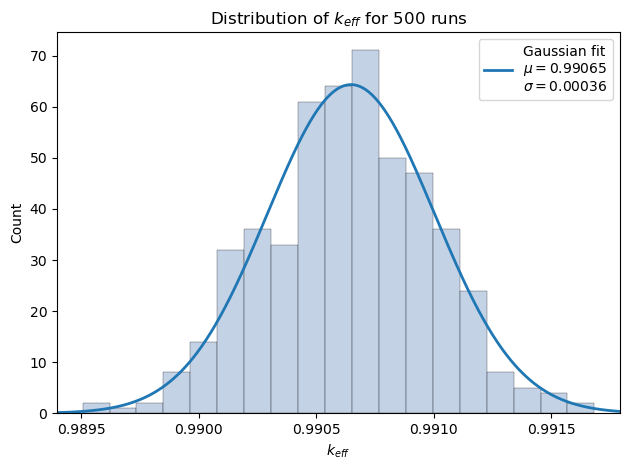

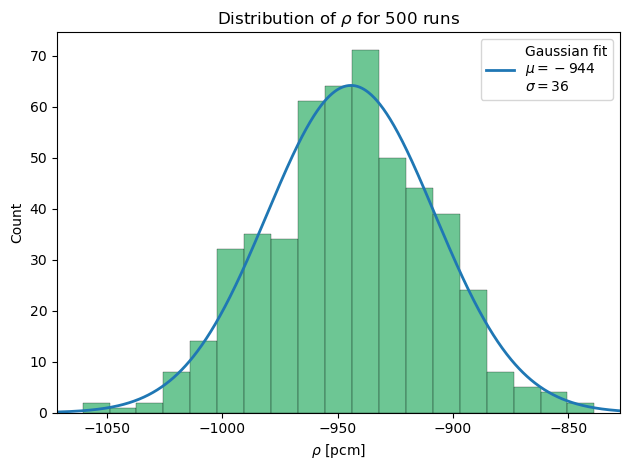

In [8]:
# PLOT SETTINGS:
FAST_REACTOR = False # True if epithermal, False if thermal
USE_SAMPLED_DATA = False

# for FAST_REACTOR in [True, False]:
#     for USE_SAMPLED_DATA in [True, False]:

NEUTRON_TEMP = "EPITHERMAL" if FAST_REACTOR else "THERMAL"
SAMPLED_STRING = "SAMPLED" if USE_SAMPLED_DATA else "NOT_SAMPLED"

folder_name = f"plots-{NEUTRON_TEMP}-{SAMPLED_STRING}"
os.makedirs(folder_name, exist_ok=True)

def get_filename(plot_type: str, value: str):
    return f"{folder_name}/{plot_type}_{value}-{NEUTRON_TEMP}-{SAMPLED_STRING}.pdf"

# Create a dataframe from the results
df = pd.DataFrame(results)

# Filters
df = df[df["fast_reactor"] == FAST_REACTOR]
df = df[df["use_sampled_data"] == USE_SAMPLED_DATA]

if df.empty:
    raise Exception("No results found!")

df = data_tools.add_reactivity_to_df(df)

plt.figure()
fig, popt, pcov = plot_tools.plot_histogram_from_df(df=df, data_key="k-eff", 
                                        fit_gaussian=True, decimals=5,
                                        title=f"Distribution of $k_{{eff}}$ for {len(df)} runs", x_label="$k_{eff}$", y_label="Count",
                                        filename=get_filename("heatmap", "distribution-k_eff"))

plt.figure()
fig, popt, pcov = plot_tools.plot_histogram_from_df(df=df, data_key="rho-pcm", color="mediumseagreen",
                                        fit_gaussian=True, decimals=0,
                                        title=fr"Distribution of $\rho$ for {len(df)} runs", x_label=r"$\rho$ [pcm]", y_label="Count",
                                        filename=get_filename("heatmap", "distribution-rho"))

In [15]:
# # TMC analysis

# FAST_REACTOR = False # True if epithermal, False if thermal
# USE_SAMPLED_DATA = True

# NEUTRON_TEMP = "EPITHERMAL" if FAST_REACTOR else "THERMAL"
# SAMPLED_STRING = "SAMPLED" if USE_SAMPLED_DATA else "NOT_SAMPLED"

# # Create a dataframe from the results
# df = pd.DataFrame(results)

# # Filters
# df = df[df["fast_reactor"] == FAST_REACTOR]
# df = df[df["use_sampled_data"] == USE_SAMPLED_DATA]

# sigma2_obs = np.std(df["k-eff"], ddof=1)
# sigma2_stat_mean = np.sum(df["k-eff-std"]**2) / len(df["k-eff-std"])
# sigma2_data = sigma2_obs - sigma2_stat_mean

# print("TMC analysis")
# print("============")
# print(f"Based on {len(df)} runs")
# print(f"σ2_obs: \t{sigma2_obs:.2e}")
# print(f"σ_obs: \t\t{np.sqrt(sigma2_obs):.2e}")
# print(f"σ2_stat_mean: \t{sigma2_stat_mean:.2e}")
# print(f"σ_stat_mean: \t{np.sqrt(sigma2_stat_mean):.2e}")
# print(f"σ2_data: \t{sigma2_data:.2e}")
# print(f"σ_data: \t{np.sqrt(sigma2_data):.2e}")

σ_sampled: 	1.29e-03
σ_not_sampled: 	3.52e-04
σ_ND: 		1.24e-03
R_sampled: 	130 pcm
R_not_sampled: 	36 pcm
R_ND: 		126 pcm


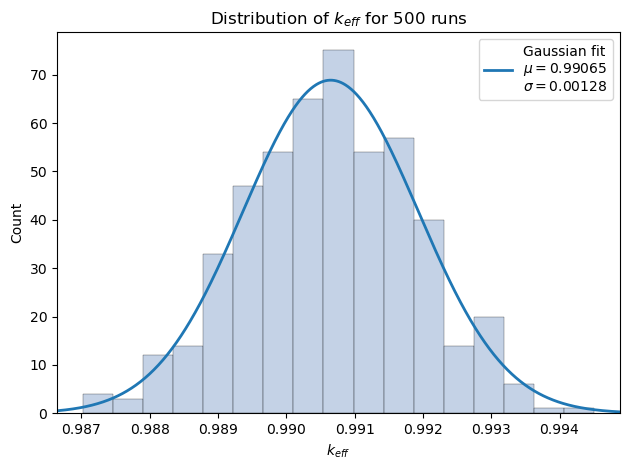

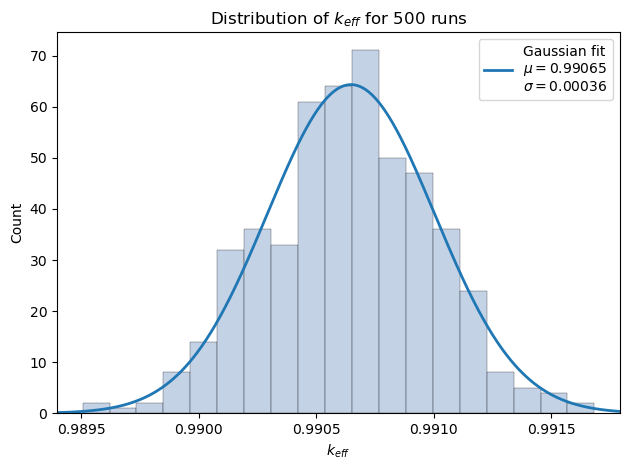

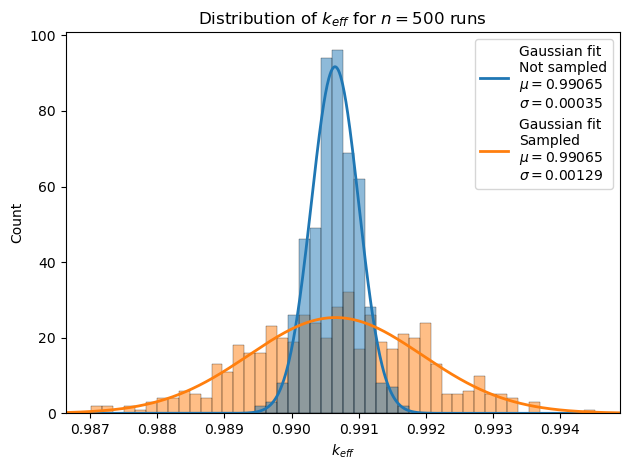

In [20]:
# 26 feb 2023 - correct TMC analysis
importlib.reload(plot_tools)

# TMC analysis

FAST_REACTOR = False # True if epithermal, False if thermal

NEUTRON_TEMP = "EPITHERMAL" if FAST_REACTOR else "THERMAL"

# Create a dataframe from the results
df = pd.DataFrame(results)

# Filters
df = df[df["fast_reactor"] == FAST_REACTOR]
df = df[df["use_sampled_data"] == True]

plt.figure()
fig_sampled, popt_sampled, pcov_sampled = plot_tools.plot_histogram_from_df(df=df[df["use_sampled_data"] == True], data_key="k-eff", 
                                        fit_gaussian=True, decimals=5,
                                        title=f"Distribution of $k_{{eff}}$ for {len(df)} runs", x_label="$k_{eff}$", y_label="Count")

# Create a dataframe from the results
df = pd.DataFrame(results)

# Filters
df = df[df["fast_reactor"] == FAST_REACTOR]
df = df[df["use_sampled_data"] == False]

plt.figure()
fig_not_sampled, popt_not_sampled, pcov_not_sampled = plot_tools.plot_histogram_from_df(df=df[df["use_sampled_data"] == False], data_key="k-eff", 
                                        fit_gaussian=True, decimals=5,
                                        title=f"Distribution of $k_{{eff}}$ for {len(df)} runs", x_label="$k_{eff}$", y_label="Count")



# Create a dataframe from the results
df = pd.DataFrame(results)

# Filters
df = df[df["fast_reactor"] == FAST_REACTOR]

plt.figure()
fig_combined, popts_combined, pcovs_combined = plot_tools.plot_histogram_from_df(df=df, data_key="k-eff", 
                                        fit_gaussian=True, decimals=5,
                                        title=f"Distribution of $k_{{eff}}$ for $n={len(df)//2}$ runs", x_label="$k_{eff}$", y_label="Count",
                                        hue="use_sampled_data", hue_order=[1,0], hue_labels=["Sampled", "Not sampled"],
                                        filename=f"combined_{NEUTRON_TEMP}.pdf")

σ_sampled = popts_combined[1][2]
σ_not_sampled = popts_combined[0][2]
σ_ND = np.sqrt(σ_sampled**2 - σ_not_sampled**2)
k_eff_mean = np.mean(df["k-eff"])
R_sampled = σ_sampled / k_eff_mean
R_not_sampled = σ_not_sampled / k_eff_mean
R_ND = σ_ND / k_eff_mean

print(f"σ_sampled: \t{σ_sampled:.2e}")
print(f"σ_not_sampled: \t{σ_not_sampled:.2e}")
print(f"σ_ND: \t\t{σ_ND:.2e}")
print(f"R_sampled: \t{(R_sampled*1e5):.0f} pcm")
print(f"R_not_sampled: \t{(R_not_sampled*1e5):.0f} pcm")
print(f"R_ND: \t\t{(R_ND*1e5):.0f} pcm")
